# Transformation Interpolations:  ComCam <--> SDSS DR2

_Meagan N.Porter_, _Douglas L. Tucker_, _Christina Adair_

_2025.10.03_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime
import re

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

%matplotlib inline

## 2.  Input Parameters

In [2]:
# ComCam-->SDSS DR18 (toComCam=False) or SDSS DR18-->ComCam (toComCam=True)...
toComCam = True
#toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    #bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'gi_ComCam']
    # If SDSS-->ComCam, then the mag and color to fit against are SDSS...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'g_sdss', 'r_ComCam':'r_sdss', 'i_ComCam':'i_sdss', 'z_ComCam':'z_sdss', 'y_ComCam':'z_sdss', 'gi_ComCam':'gi_sdss'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'gi_sdss', 'r_ComCam':'gi_sdss', 'i_ComCam':'gi_sdss', 'z_ComCam':'gi_sdss', 'y_ComCam':'gi_sdss', 'gi_ComCam':'gi_sdss'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(g-i)_{sdss}$', 'r_ComCam':'$(g-i)_{sdss}$', 'i_ComCam':'$(g-i)_{sdss}$', 'z_ComCam':'$(g-i)_{sdss}$', 'y_ComCam':'$(g-i)_{sdss}$', 'gi_ComCam':'$(g-i)_{sdss}$'}

else:
    # List of SDSS bands on which to run the transform fit...
    bandList = ['g_sdss', 'r_sdss', 'i_sdss', 'z_sdss','gi_sdss']
    # If ComCam-->SDSS, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_sdss':'g_ComCam', 'r_sdss':'r_ComCam', 'i_sdss':'i_ComCam', 'z_sdss':'z_ComCam', 'y_sdss':'z_ComCam', 'gi_sdss':'gi_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'g_sdss':'gi_ComCam', 'r_sdss':'gi_ComCam', 'i_sdss':'gi_ComCam', 'z_sdss':'gi_ComCam', 'y_sdss':'gi_ComCam', 'gi_sdss':'gi_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_sdss':'$(g-i)_{ComCam}$', 'r_sdss':'$(g-i)_{ComCam}$', 'i_sdss':'$(g-i)_{ComCam}$', 'z_sdss':'$(g-i)_{ComCam}$', 'y_sdss':'$(g-i)_{ComCam}$', 'gi_sdss':'$(g-i)_{ComCam}$'}

# Size of the binsize in color
color_binsize = 0.2

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# SDSS DR18 TAP service
#sdssdr18_tap_url = 'https://mast.stsci.edu/vo-tap/api/v0.1/sdssdr18 - TBD'

# Name of the SDSS file (if it exists)
sdssFile = '/home/d/dltucker/DATA/LSST_DP1_AREAS_2_dtucker.csv'

#use match file?
useMatchFile = False

# Name of the match file
#matchFile = '/home/d/dltucker/DATA/match.comcam_stars_all.w_2025_10.DM-49359a.SDSS_DR18.csv'
matchFile = './match.comcam_stars_all.DP1.SDSS_DR18.csv'



# Base name of fit results output file...
if toComCam:
    resultsFileBaseName = 'transInterp.SDSSDR18_to_ComCam'
else:
    resultsFileBaseName = 'transInterp.ComCam_to_SDSSDR18'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.SDSSDR18_to_ComCam.interp.fit'
else:
    qaFileBaseName = 'qaPlot.SDSSDR18_to_ComCam.interp.fit'

# Write a Markdown-formatted summary table of the fits?
write_md_file = True
if write_md_file:
    # Auto-name the .md file based on resultsFileBaseName
    #md_filename = f"{qaFileBaseName}.qa_summary.md"
    md_filename = f"{resultsFileBaseName}.qa_summary.md"

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }


## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Create a new dataframe with matches
    matches = df1[mask].copy()
    matches['match_idx'] = idx[mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        matches[f'match_{col}'] = df2.loc[idx[mask], col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~mask]

    return matches, unmatched

In [5]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    return uncMedian

In [6]:
##################################

def interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                         title, dmagLabel, outputFileName, verbose):

        
    # Create linear interpolation of the median dmag vs. color bin calculated above...
    response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    

    # Calculate and apply the offset for the individual stars in df, 
    #  based on the linear interpolation calculated above...
    df['offset'] = response(df[color_name_1].values)    
    df['res'] = df['dmag'] - df['offset']    
    if verbose>1:
        print("") 
        print(df[[color_name_1, 'offset', 'res']].head())
        print("")

    # Calculate the 'robust' RMS of the residuals....
    rms = robustStdDev(df['res'].values)


    # Identify range to plot in the dmag (Y-axis) direction...
    dmag_desc = df['dmag'].describe(percentiles=[0.001, 0.999])
    if verbose>1:
        print(dmag_desc)
    dmag_min = math.floor(10*dmag_desc['0.1%'])/10.
    dmag_max = math.ceil(10*dmag_desc['99.9%'])/10.

    dmag_mask = (df['dmag'] >= dmag_min) & (df['dmag'] <= dmag_max)
    df_dmag_mask = df[dmag_mask]
    

    # Identify range to plot in the residuals (Y-axis) direction...
    res_desc = df['res'].describe(percentiles=[0.01, 0.99])
    if verbose>1:
        print("")
        print(res_desc)
        print("") 
    res_min = math.floor(10*res_desc['1%'])/10.
    res_max = math.ceil(10*res_desc['99%'])/10.
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10
    res_min = -0.20
    res_max = +0.20


    # For 2d binning below, we mask df for just those stars within 
    #  the res_min, res_max range...
    res_mask = (df['res'] >= res_min) & (df['res'] <= res_max)
    df_res_mask = df[res_mask]
    
    
    # Prepare QA plots...
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    
    # Modify matplotlib font...
    #font = {'family' : 'normal',
    #        'weight' : 'bold',
    #       'size'   : 22}
    #matplotlib.rc('font', **font)    
    plt.rcParams.update({'font.size': 24})

    
    ## Include a supertitle to the matplotlob figure...
    #fig.suptitle('This is the superTitle')

    
    # Plot 1:  Descriptive text...
    plt.subplot(221)
    plot1Text = """%s \n\n\n\n%s vs. %s\n\n[rms: %.3f] \n\n[%.1f < %s < %.1f]""" % \
                    (title, dmagLabel, colorLabel_1, rms, color1_min, colorLabel_1, color1_max)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(222)
    if len(df_dmag_mask['dmag'].values) < 1000:
        plt.scatter(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, alpha=0.75, label='Data')
    else:
        # The color of the Data label does not look appropriate; 
        #  so let's just omit it from the legend when doing the hexbin plot
        #hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
        #                  gridsize=100, bins='log', cmap='inferno', label='Data')
        hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
                          gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel(dmagLabel)
    if len(df_dmag_mask['dmag'].values) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)
    # Overplot the binned values calculated above:
    plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, 
                 fmt='o', c='lime', label='Bin Median')
    #try:
        #plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')
    #except:
        #plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, fmt='o', markersize=10)
    plt.legend()

    
    # Plot 3:  1d histogram of residuals...
    plt.subplot(223) 
    plt.hist(df_res_mask.loc[:,'res'],bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.xlim([res_min, res_max])
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(224) 
    if len(df_dmag_mask['dmag'].values) < 1000:
        plt.scatter(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, alpha=0.75)
    else:
        hb=plt.hexbin(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, \
                      gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel('Residuals')
    if len(df_dmag_mask['dmag'].values) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)
    plt.legend()
    
    
    # Plot...
    plt.tight_layout()
    

    # Save QA plots to file...
    plt.savefig(outputFileName)    
    

    return 0


##################################

In [7]:
# Kudos to Copilot ChatGPT-5 for these functions for generating Markdown output 
#  of the fit equations...
# See:  https://copilot.microsoft.com/shares/Nopgin8hutEqEmjqJkteY

def latexify_label(label: str) -> str:
    """Strip $ and convert underscores to LaTeX subscripts."""
    label = label.strip('$')
    return re.sub(r'_(\w+)', r'_{\1}', label)

def latexify_name(name: str) -> str:
    """Convert underscores in names to LaTeX subscripts."""
    return re.sub(r'_(\w+)', r'_{\1}', name)

def make_conversion_str(magName_match, magName):
    """Return a LaTeX conversion string like $g_{ComCam} \to g_{DES}$."""
    return f"${latexify_name(magName_match)} \\to {latexify_name(magName)}$"

def make_range_str_interp(color_min, color_max, colorLabel_1):
    """Return a LaTeX range string for the lookup table case."""
    label = latexify_label(colorLabel_1)
    return f"${color_min:.1f} < {label} < {color_max:.1f}$"

## X. Read in Matched Catalog

In [8]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


In [9]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    tab

In [10]:
if useMatchFile:
    matches = tab.to_pandas()
    matches

## 4. Query ComCam Catalog

In [11]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [12]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [13]:
# Download all DP1 stars with SNR>5 in the r-band psfFluxstars...
if not useMatchFile:
    comcam_stars_list = []
    ra_min = {}
    ra_max = {}
    dec_min = {}
    dec_max = {}


    for tractId in tract_list:

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")

            # Find the bounding (ra,dec)'s for each DP1 tractId: 
            ra_min[tractId] = comcam_stars.coord_ra.min()
            ra_max[tractId] = comcam_stars.coord_ra.max()
            dec_min[tractId] = comcam_stars.coord_dec.min()
            dec_max[tractId] = comcam_stars.coord_dec.max()
            print(tractId, ra_min[tractId], ra_max[tractId], dec_min[tractId], dec_max[tractId])

            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")

453 47 Tuc
Number of objects: 49962
Number of stars: 9872
453 4.339320403393294 6.9230561484409705 -72.66605865167178 -71.58849158406078
454 47 Tuc
Number of objects: 966
Number of stars: 117
454 6.923337851991782 7.416546836171249 -72.52399059984855 -71.69660515337513
4849 ECDFS
Number of objects: 58807
Number of stars: 2433
4849 52.99091730906144 53.76753331292985 -28.716939392158658 -28.264519218427996
5063 ECDFS
Number of objects: 206560
Number of stars: 7859
5063 52.407997082811164 53.874488721158265 -28.264420841505903 -27.501464859634126
4848 ECDFS
Number of objects: 32195
Number of stars: 1318
4848 52.45839219772449 52.99050310041351 -28.685268804382048 -28.26455785437049
2394 EDFS
Number of objects: 175982
Number of stars: 7512
2394 58.25147275794764 60.005149850454124 -49.090869929685795 -48.15954346386123
2234 EDFS
Number of objects: 21753
Number of stars: 1222
2234 58.47680153705461 59.84534419709791 -49.367826757675296 -49.091719991470995
4016 Fornax
Number of objects: 856

In [14]:
if not useMatchFile:
    display(comcam_stars_all)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


In [15]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

4.339320403393294 95.70060612307906 -72.66605865167178 7.969936691740922


## 5. Query SDSS DR18 Catalog

***THIS SECTION NEEDS WORK!***

Ideally, we would query the SDSS CasJobs directly from this current Jupyter notebook via the SciScript-Python library ( https://github.com/sciserver/SciScript-Python ), following methodology described in this example SciServer Jupyter notebook:  https://github.com/sciserver/Example-Notebooks/blob/main/SciServer%20Components%20-%20Python%20Examples/CasJobs.ipynb


Here, we merely queried SDSS CasJobs directly using this query:

```
SELECT  
  dbo.fIAUFromEq(s.ra, s.dec) as name, 
  s.ra,s.dec,
  s.psfMag_u,s.psfMag_g,s.psfMag_r,s.psfMag_i,s.psfMag_z,
  s.psfMagErr_u,s.psfMagErr_g,s.psfMagErr_r,s.psfMagErr_i,s.psfMagErr_z,
  r.run,r.stripe  
INTO mydb.LSST_DP1_AREAS_2
FROM Star s, Run r
WHERE
  s.run = r.run
  AND ( (s.ra BETWEEN   1.0 AND  11.0 AND s.dec BETWEEN -77. AND -67.) 
    OR  (s.ra BETWEEN  33.0 AND  43.0 AND s.dec BETWEEN   2. AND  12.)
    OR  (s.ra BETWEEN  35.0 AND  45.0 AND s.dec BETWEEN -39. AND -29.)
    OR  (s.ra BETWEEN  48.0 AND  58.0 AND s.dec BETWEEN -33. AND -23.)
    OR  (s.ra BETWEEN  54.0 AND  64.0 AND s.dec BETWEEN -54. AND -44.)
    OR  (s.ra BETWEEN  90.0 AND 100.0 AND s.dec BETWEEN -30. AND -20.)
    OR  (s.ra BETWEEN 101.0 AND 111.0 AND s.dec BETWEEN -16. AND  -6.) )
  AND ((s.flags_u & 0x10000000) != 0) AND ((s.flags_g & 0x10000000) != 0) AND ((s.flags_r & 0x10000000) != 0) AND ((s.flags_i & 0x10000000) != 0) AND ((s.flags_z & 0x10000000) != 0) 
  AND ((s.flags_u & 0x8100000c00a4) = 0) AND ((s.flags_g & 0x8100000c00a4) = 0) AND ((s.flags_r & 0x8100000c00a4) = 0) AND ((s.flags_i & 0x8100000c00a4) = 0) AND ((s.flags_z & 0x8100000c00a4) = 0)     
  AND (((s.flags_u & 0x400000000000) = 0) or (s.psfmagerr_u <= 0.2)) AND (((s.flags_g & 0x400000000000) = 0) or (s.psfmagerr_g <= 0.2)) AND (((s.flags_r & 0x400000000000) = 0) or (s.psfmagerr_r <= 0.2)) 
  AND (((s.flags_i & 0x400000000000) = 0) or (s.psfmagerr_i <= 0.2)) AND (((s.flags_z & 0x400000000000) = 0) or (s.psfmagerr_z <= 0.2)) 
  AND (((s.flags_u & 0x100000000000) = 0) or (s.flags_u & 0x1000) = 0) AND (((s.flags_g & 0x100000000000) = 0) or (s.flags_g & 0x1000) = 0) AND (((s.flags_r & 0x100000000000) = 0) or (s.flags_r & 0x1000) = 0) 
  AND (((s.flags_i & 0x100000000000) = 0) or (s.flags_i & 0x1000) = 0) AND (((s.flags_z & 0x100000000000) = 0) or (s.flags_z & 0x1000) = 0)
```

and downloaded the result as `LSST_DP1_AREAS_2_dtucker.csv`.

In [16]:
# Invoke TAP service to SDSS DR18 data....
#if not useMatchFile:
#    ps1dr2_tap = pyvo.dal.TAPService(ps1dr2_tap_url)

In [17]:
# Check to make sure sdssFile exists...
if not useMatchFile:
    if os.path.isfile(sdssFile)==False:
        print("""ERROR:  sdssFile %s does not exist...""" % (sdssFile))
    if verbose > 0:
        print('sdssFile: ', sdssFile)

sdssFile:  /home/d/dltucker/DATA/LSST_DP1_AREAS_2_dtucker.csv


In [18]:
# Read sdssFile into Astropy table...
if not useMatchFile:
    tab = Table.read(sdssFile, format='csv')
    display(tab)

name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
SDSS J021550.15+115734.5,33.9589938257464,11.9595945462486,21.13038,19.09241,18.23106,17.88484,17.73732,0.07995148,0.01941827,0.01266304,0.02131455,0.02438181,1035,76
SDSS J021544.43+115949.8,33.9351622132347,11.9971853049534,20.35628,18.20708,17.28342,16.87744,16.66385,0.04626199,0.01831319,0.01173055,0.02076917,0.02002777,1035,76
SDSS J021539.29+115731.1,33.9137228889019,11.9586418038128,20.53274,18.94599,18.46925,18.33302,18.32562,0.05242241,0.01975724,0.01433168,0.02272148,0.03238435,1035,76
SDSS J021538.74+115737.0,33.9114273088492,11.9602984801481,19.29841,16.77432,15.72098,15.31517,15.11231,0.02757291,0.01776804,0.01131681,0.02056196,0.01874357,1035,76
SDSS J021507.91+115659.2,33.7829682518441,11.9497977519655,22.17539,21.15931,20.68056,20.59957,20.31684,0.1805407,0.04285426,0.03726304,0.04939352,0.1409537,1035,76
SDSS J021450.05+115846.7,33.7085816266403,11.979639144017,22.19207,20.77297,20.0984,19.83024,19.78315,0.1807895,0.03330931,0.02685664,0.03203157,0.08686283,1035,76
SDSS J021515.78+115901.3,33.8157656578845,11.9837113943172,21.39572,18.63664,17.25244,16.66732,16.25866,0.08943402,0.01870308,0.01170767,0.02071503,0.01943634,1035,76
SDSS J021428.44+115826.4,33.6185259735859,11.9740211526981,17.31712,16.03934,15.52451,15.29827,15.21681,0.01569046,0.01696694,0.01547018,0.01585862,0.02039249,1035,76
SDSS J021428.77+115915.7,33.6199083848434,11.9877190250852,18.59392,17.26357,16.67941,16.43834,16.3575,0.01941603,0.0171741,0.01561113,0.01601245,0.02111997,1035,76


In [19]:
# Convert Astropy table of sdssFile contents into a Pandas DataFrame...
if not useMatchFile:
    combined_df = tab.to_pandas()
    display(combined_df)
    

,name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe
0,SDSS J021550.15+115734.5,33.958994,11.959595,21.13038,19.09241,18.23106,17.88484,17.73732,0.079951,0.019418,0.012663,0.021315,0.024382,1035,76
1,SDSS J021544.43+115949.8,33.935162,11.997185,20.35628,18.20708,17.28342,16.87744,16.66385,0.046262,0.018313,0.011731,0.020769,0.020028,1035,76
2,SDSS J021539.29+115731.1,33.913723,11.958642,20.53274,18.94599,18.46925,18.33302,18.32562,0.052422,0.019757,0.014332,0.022721,0.032384,1035,76
3,SDSS J021538.74+115737.0,33.911427,11.960298,19.29841,16.77432,15.72098,15.31517,15.11231,0.027573,0.017768,0.011317,0.020562,0.018744,1035,76
4,SDSS J021507.91+115659.2,33.782968,11.949798,22.17539,21.15931,20.68056,20.59957,20.31684,0.180541,0.042854,0.037263,0.049394,0.140954,1035,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272223,SDSS J023258.24+051534.3,38.242677,5.259547,20.02589,18.74767,18.25705,18.04773,17.95744,0.038464,0.023539,0.018230,0.014212,0.024500,5714,79
272224,SDSS J023301.91+051849.6,38.257965,5.313805,20.42156,18.16438,17.16310,16.75878,16.55019,0.049386,0.023058,0.017561,0.013071,0.018705,5714,79
272225,SDSS J023304.71+051651.5,38.269662,5.280986,20.12243,18.06005,17.20651,16.88618,16.70032,0.040832,0.022991,0.017573,0.013127,0.018951,5714,79
272226,SDSS J023307.35+051738.7,38.280648,5.294109,20.08212,18.73066,18.08077,17.77385,17.58752,0.039694,0.023553,0.018060,0.013791,0.021929,5714,79


In [20]:
if not useMatchFile:
    display(combined_df)

,name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe
0,SDSS J021550.15+115734.5,33.958994,11.959595,21.13038,19.09241,18.23106,17.88484,17.73732,0.079951,0.019418,0.012663,0.021315,0.024382,1035,76
1,SDSS J021544.43+115949.8,33.935162,11.997185,20.35628,18.20708,17.28342,16.87744,16.66385,0.046262,0.018313,0.011731,0.020769,0.020028,1035,76
2,SDSS J021539.29+115731.1,33.913723,11.958642,20.53274,18.94599,18.46925,18.33302,18.32562,0.052422,0.019757,0.014332,0.022721,0.032384,1035,76
3,SDSS J021538.74+115737.0,33.911427,11.960298,19.29841,16.77432,15.72098,15.31517,15.11231,0.027573,0.017768,0.011317,0.020562,0.018744,1035,76
4,SDSS J021507.91+115659.2,33.782968,11.949798,22.17539,21.15931,20.68056,20.59957,20.31684,0.180541,0.042854,0.037263,0.049394,0.140954,1035,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272223,SDSS J023258.24+051534.3,38.242677,5.259547,20.02589,18.74767,18.25705,18.04773,17.95744,0.038464,0.023539,0.018230,0.014212,0.024500,5714,79
272224,SDSS J023301.91+051849.6,38.257965,5.313805,20.42156,18.16438,17.16310,16.75878,16.55019,0.049386,0.023058,0.017561,0.013071,0.018705,5714,79
272225,SDSS J023304.71+051651.5,38.269662,5.280986,20.12243,18.06005,17.20651,16.88618,16.70032,0.040832,0.022991,0.017573,0.013127,0.018951,5714,79
272226,SDSS J023307.35+051738.7,38.280648,5.294109,20.08212,18.73066,18.08077,17.77385,17.58752,0.039694,0.023553,0.018060,0.013791,0.021929,5714,79


## 6. Match ComCam and SDSS DR18 stars

In [21]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'ra', 'dec')

In [22]:
if not useMatchFile:
    display(matches)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,match_psfMag_r,match_psfMag_i,match_psfMag_z,match_psfMagErr_u,match_psfMagErr_g,match_psfMagErr_r,match_psfMagErr_i,match_psfMagErr_z,match_run,match_stripe
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.07397,21.10184,20.83660,0.184898,0.050783,0.043836,0.059631,0.174584,5714,79
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,18.26612,17.54243,17.10579,0.200714,0.023394,0.015392,0.021294,0.018432,5714,79
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,16.63436,16.34908,16.17324,0.030322,0.016116,0.012756,0.013733,0.018250,5714,79
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,19.83786,19.61528,19.45786,0.104424,0.024509,0.020414,0.021852,0.056346,5714,79
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,17.84156,17.00615,16.50266,0.180355,0.018177,0.013395,0.013941,0.018636,5714,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,16.83854,16.51228,16.31126,0.044484,0.017988,0.014561,0.016319,0.020111,5714,79
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,17.06999,16.74650,16.55591,0.039308,0.016022,0.015586,0.015156,0.017491,5714,79
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,18.28275,18.11397,18.01822,0.037891,0.018752,0.015628,0.017717,0.027277,5714,79
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,16.20010,15.81489,15.55600,0.032349,0.017783,0.014426,0.016182,0.019530,5714,79


In [23]:
if not useMatchFile:
    matches.to_csv(matchFile, index=False)

In [24]:
if not useMatchFile:
    display(unmatched)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


##  7. Add ABmag Columns to Matched Catalog Data Frame

In [25]:
# Copy matches to df...
df = matches.copy()

In [26]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = df[flux_col] > 0

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



In [27]:
df

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.639744,0.008162,21.274864,0.012370,21.123447,0.013443,-9999.000000,-9999.000000,-9999.0,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,19.599087,0.001914,18.260489,0.001653,17.519871,0.001055,-9999.000000,-9999.000000,-9999.0,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,17.352592,0.000509,16.629280,0.000757,16.358074,0.000459,-9999.000000,-9999.000000,-9999.0,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,20.422182,0.002813,19.870197,0.004315,19.650673,0.003188,-9999.000000,-9999.000000,-9999.0,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,19.182320,0.001291,17.855909,0.001340,16.992954,0.000623,-9999.000000,-9999.000000,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,17.702740,0.001341,16.833950,0.000610,16.507435,0.000591,16.370710,0.000760,-9999.0,-9999.0
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,17.774719,0.001125,17.071772,0.000503,16.761013,0.000495,16.619833,0.000765,-9999.0,-9999.0
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,18.705177,0.002221,18.284494,0.001117,18.106590,0.001133,18.025154,0.002385,-9999.0,-9999.0
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,17.131617,0.001460,16.224667,0.000579,15.813975,0.000430,15.632690,0.000514,-9999.0,-9999.0


In [28]:
df.columns

Index(['tractId', 'field', 'coord_ra', 'coord_dec', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'match_idx',
       'separation_arcsec', 'match_name', 'match_ra', 'match_dec',
       'match_psfMag_u', 'match_psfMag_g', 'match_psfMag_r', 'match_psfMag_i',
       'match_psfMag_z', 'match_psfMagErr_u', 'match_psfMagErr_g',
       'match_psfMagErr_r', 'match_psfMagErr_i', 'match_psfMagErr_z',
       'match

In [29]:
# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'u_psfMag':'u_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'u_psfMagErr':'u_err_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'match_psfMag_u':'u_sdss',
                   'match_psfMag_g':'g_sdss',
                   'match_psfMag_r':'r_sdss',
                   'match_psfMag_i':'i_sdss',
                   'match_psfMag_z':'z_sdss',
                   'match_psfMagErr_u':'u_err_sdss',
                   'match_psfMagErr_g':'g_err_sdss',
                   'match_psfMagErr_r':'r_err_sdss',
                   'match_psfMagErr_i':'i_err_sdss',
                   'match_psfMagErr_z':'z_err_sdss'
                  },inplace=True)

df.head(5)

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.639744,0.008162,21.274864,0.012370,21.123447,0.013443,-9999.0,-9999.0,-9999.0,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,19.599087,0.001914,18.260489,0.001653,17.519871,0.001055,-9999.0,-9999.0,-9999.0,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,17.352592,0.000509,16.629280,0.000757,16.358074,0.000459,-9999.0,-9999.0,-9999.0,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,20.422182,0.002813,19.870197,0.004315,19.650673,0.003188,-9999.0,-9999.0,-9999.0,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,19.182320,0.001291,17.855909,0.001340,16.992954,0.000623,-9999.0,-9999.0,-9999.0,-9999.0


In [30]:
df.columns

Index(['tractId', 'field', 'RA_ComCam', 'DEC_ComCam', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'match_idx',
       'separation_arcsec', 'match_name', 'match_ra', 'match_dec', 'u_sdss',
       'g_sdss', 'r_sdss', 'i_sdss', 'z_sdss', 'u_err_sdss', 'g_err_sdss',
       'r_err_sdss', 'i_err_sdss', 'z_err_sdss', 'match_run', 'match_stripe',
       'u_ComCam', 'u_err_ComCam', 'g_ComCam', 'g_err_ComCam', '

## 8. Add Color Columns to Matched Catalog Data Frame

In [31]:
# Add color columns...
df.loc[:,'ug_ComCam'] = df.loc[:,'u_ComCam'] - df.loc[:,'g_ComCam']
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']


In [32]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## 9. Create Initial Mask

In [33]:
mask1 = (df["u_sdss"] > 0.) & (df["u_sdss"] < 30.)
mask2 = (df["g_sdss"] > 0.) & (df["g_sdss"] < 30.)
mask3 = (df["r_sdss"] > 0.) & (df["r_sdss"] < 30.)
mask4 = (df["i_sdss"] > 0.) & (df["i_sdss"] < 30.)
mask5 = (df["z_sdss"] > 0.) & (df["z_sdss"] < 30.)
mask6 = df["u_err_sdss"] <= 0.06
mask7 = df["g_err_sdss"] <= 0.02
mask8 = df["r_err_sdss"] <= 0.02
mask9 = df["i_err_sdss"] <= 0.02
mask10 = df["z_err_sdss"] <= 0.02
mask_sdss = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask1 = (df["g_ComCam"] > 0.) & (df["g_ComCam"] < 30.)
mask2 = (df["r_ComCam"] > 0.) & (df["r_ComCam"] < 30.)
mask3 = (df["i_ComCam"] > 0.) & (df["i_ComCam"] < 30.)
mask4 = (df["z_ComCam"] > 0.) & (df["z_ComCam"] < 30.)
mask5 = (df["y_ComCam"] > 0.) & (df["y_ComCam"] < 30.)
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.02

# No ComCam y-band for overlapping SDSS!
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask6 & mask7 & mask8 & mask9
# No ComCam y-band and little ComCam z-band for overlapping SDSS!
mask_ComCam = mask1 & mask2 & mask3 & mask6 & mask7 & mask8


mask = mask_sdss & mask_ComCam
#mask = mask_ComCam

In [34]:
df

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,ug_sdss,gr_sdss,ri_sdss,iz_sdss,gi_sdss,dmag
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,0.151417,10020.123047,0.000000,0.516296,0.41118,0.60208,-0.02787,0.26524,0.57421,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,0.740618,10016.519531,0.000000,2.079216,2.36485,1.45742,0.72369,0.43664,2.18111,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,0.271206,10015.358398,0.000000,0.994518,2.08286,0.77486,0.28528,0.17584,1.06014,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,0.219524,10018.650391,0.000000,0.771509,0.97738,0.60636,0.22258,0.15742,0.82894,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,0.862955,10015.993164,0.000000,2.189365,2.82005,1.43684,0.83541,0.50349,2.27225,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,0.326515,0.136724,10015.371094,1.195305,2.30766,0.94909,0.32626,0.20102,1.27535,-9999.0
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,0.310759,0.141180,10015.620117,1.013706,1.77929,0.78239,0.32349,0.19059,1.10588,-9999.0
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,0.177904,0.081436,10017.025391,0.598587,1.08300,0.46114,0.16878,0.09575,0.62992,-9999.0
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,0.410691,0.181285,10014.632812,1.317641,2.29145,1.00245,0.38521,0.25889,1.38766,-9999.0


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [35]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Generate Lookup Table in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    185.000000
mean       1.051439
std        0.449970
min        0.310570
1%         0.458652
50%        0.926820
99%        2.467760
max        2.994580
Name: gi_sdss, dtype: float64
0.4 2.5

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6]
[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5]

       gi_sdss bin_interval bin_label
69807  1.06014   (1.0, 1.2]       1.1
69866  0.83643   (0.8, 1.0]       0.9
69963  0.94588   (0.8, 1.0]       0.9
69968  0.66994   (0.6, 0.8]       0.7
69999  0.58630   (0.4, 0.6]       0.5


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.5         (0.4, 0.6]       10 -0.026543    0.010463    0.003488   -0.026782   
0.7         (0.6, 0.8]       44 -0.036428    0.014598    0.0022

/tmp/ipykernel_13469/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_13469/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
r_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    185.000000
mean       1.051439
std        0.449970
min        0.310570
1%         0.458652
50%        0.926820
99%        2.467760
max        2.994580
Name: gi_sdss, dtype: float64
0.4 2.5

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6]
[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5]

       gi_sdss bin_interval bin_label
69807  1.06014   (1.0, 1.2]       1.1
69866  0.83643   (0.8, 1.0]       0.9
69963  0.94588   (0.8, 1.0]       0.9
69968  0.66994   (0.6, 0.8]       0.7
69999  0.58630   (0.4, 0.6]       0.5


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.5         (0.4, 0.6]       10  0.002661    0.016220    0.005407    0.000805   
0.7         (0.6, 0.8]       44  0.002891    0.012661    0.0019

/tmp/ipykernel_13469/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_13469/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
i_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    185.000000
mean       1.051439
std        0.449970
min        0.310570
1%         0.458652
50%        0.926820
99%        2.467760
max        2.994580
Name: gi_sdss, dtype: float64
0.4 2.5

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6]
[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5]

       gi_sdss bin_interval bin_label
69807  1.06014   (1.0, 1.2]       1.1
69866  0.83643   (0.8, 1.0]       0.9
69963  0.94588   (0.8, 1.0]       0.9
69968  0.66994   (0.6, 0.8]       0.7
69999  0.58630   (0.4, 0.6]       0.5


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.5         (0.4, 0.6]       10  0.012214    0.015032    0.005011    0.009515   
0.7         (0.6, 0.8]       44  0.015763    0.020738    0.0031

/tmp/ipykernel_13469/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_13469/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
z_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    176.000000
mean       1.060987
std        0.454763
min        0.310570
1%         0.485002
50%        0.929540
99%        2.490908
max        2.994580
Name: gi_sdss, dtype: float64
0.4 2.5

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6]
[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5]

       gi_sdss bin_interval bin_label
69866  0.83643   (0.8, 1.0]       0.9
69999  0.58630   (0.4, 0.6]       0.5
70011  1.39330   (1.2, 1.4]       1.3
70018  0.68603   (0.6, 0.8]       0.7
70644  1.00652   (1.0, 1.2]       1.1


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.5         (0.4, 0.6]       10  0.041814    0.011853    0.003951    0.037744   
0.7         (0.6, 0.8]       41  0.046298    0.014963    0.0023

/tmp/ipykernel_13469/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_13469/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
gi_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    185.000000
mean       1.051439
std        0.449970
min        0.310570
1%         0.458652
50%        0.926820
99%        2.467760
max        2.994580
Name: gi_sdss, dtype: float64
0.4 2.5

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6]
[0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5]

       gi_sdss bin_interval bin_label
69807  1.06014   (1.0, 1.2]       1.1
69866  0.83643   (0.8, 1.0]       0.9
69963  0.94588   (0.8, 1.0]       0.9
69968  0.66994   (0.6, 0.8]       0.7
69999  0.58630   (0.4, 0.6]       0.5


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.5         (0.4, 0.6]       10 -0.038757    0.019677    0.006559   -0.030811   
0.7         (0.6, 0.8]       44 -0.052191    0.028132    0.004

/tmp/ipykernel_13469/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_13469/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



| Conversion                  |   RMS | Applicable Color Range     | QA Plot                                                                           | Lookup Table                                                              |
|:----------------------------|------:|:---------------------------|:----------------------------------------------------------------------------------|:--------------------------------------------------------------------------|
| $g_{sdss} \to g_{ComCam}$   | 0.015 | $0.4 < (g-i)_{sdss} < 2.5$ | [link](_static/plots/qaPlot_transInterp.SDSSDR18_to_ComCam.g_ComCam_gi_sdss.png)  | [link](_static/data/transInterp.SDSSDR18_to_ComCam.g_ComCam_gi_sdss.csv)  |
| $r_{sdss} \to r_{ComCam}$   | 0.012 | $0.4 < (g-i)_{sdss} < 2.5$ | [link](_static/plots/qaPlot_transInterp.SDSSDR18_to_ComCam.r_ComCam_gi_sdss.png)  | [link](_static/data/transInterp.SDSSDR18_to_ComCam.r_ComCam_gi_sdss.csv)  |
| $i_{sdss} \to i_{ComCam}$   | 0.013 | $0.4 < (g-i)_{sdss} < 2.5$ | [link](_static/

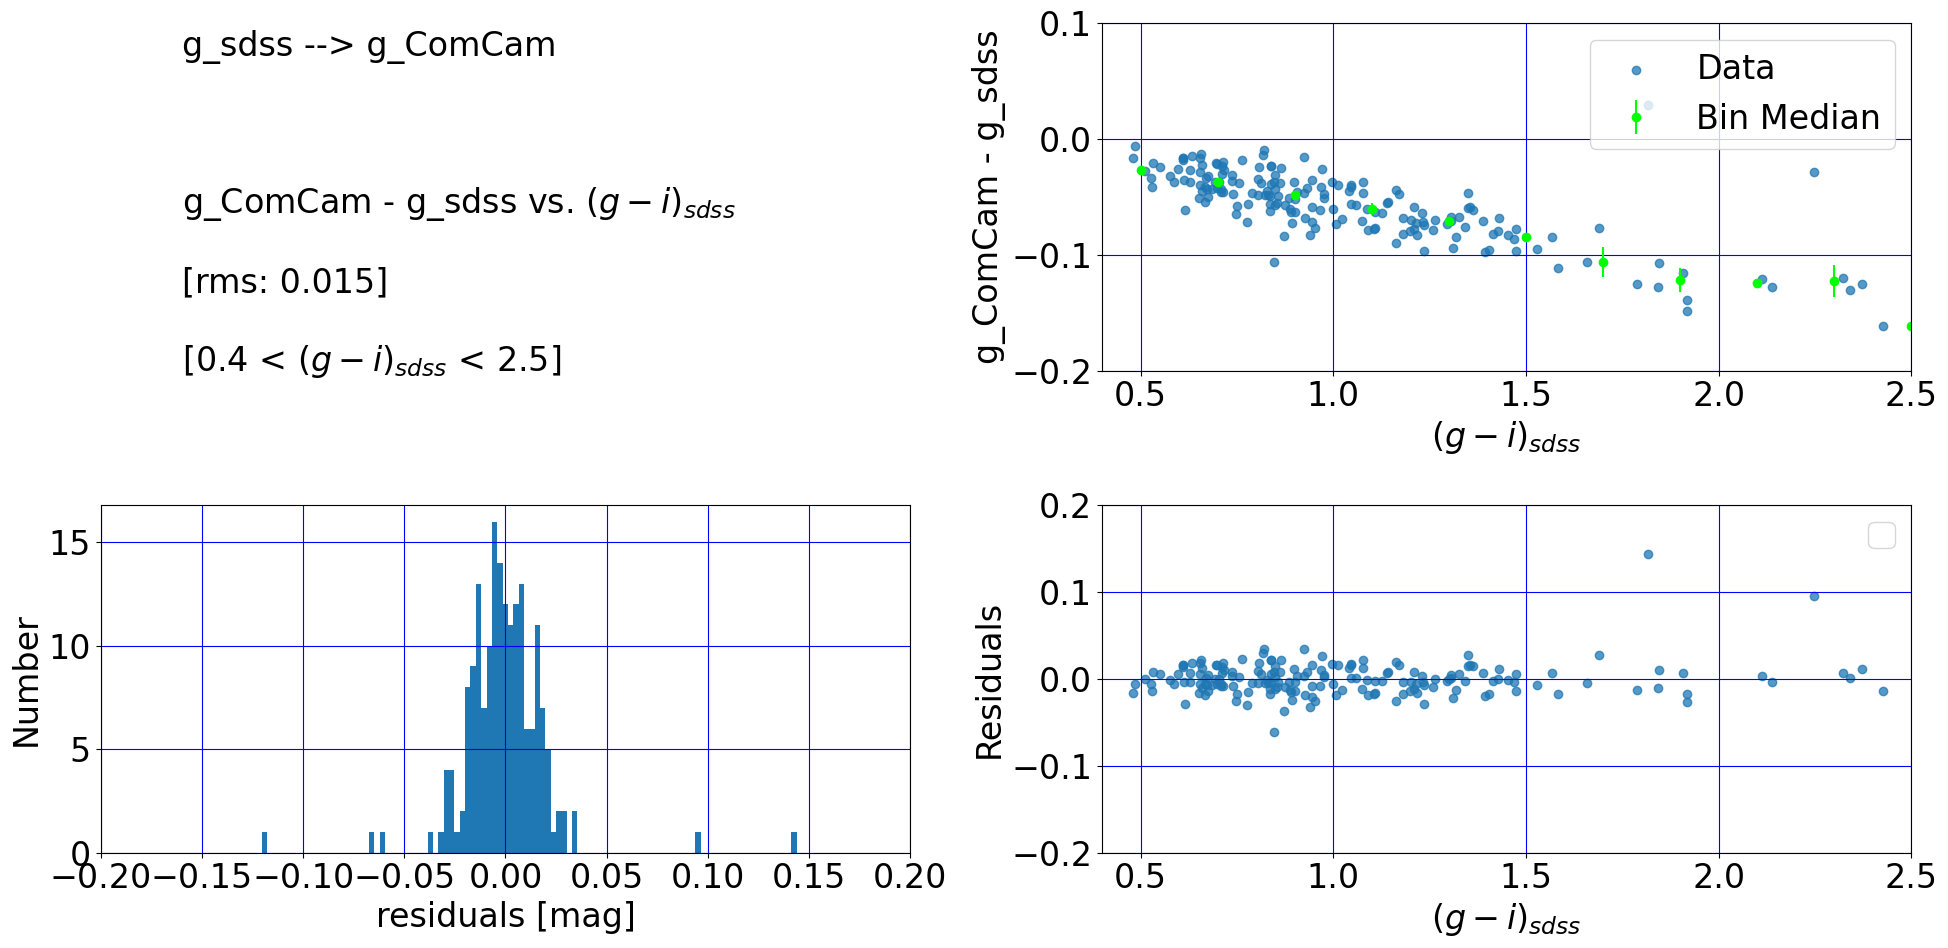

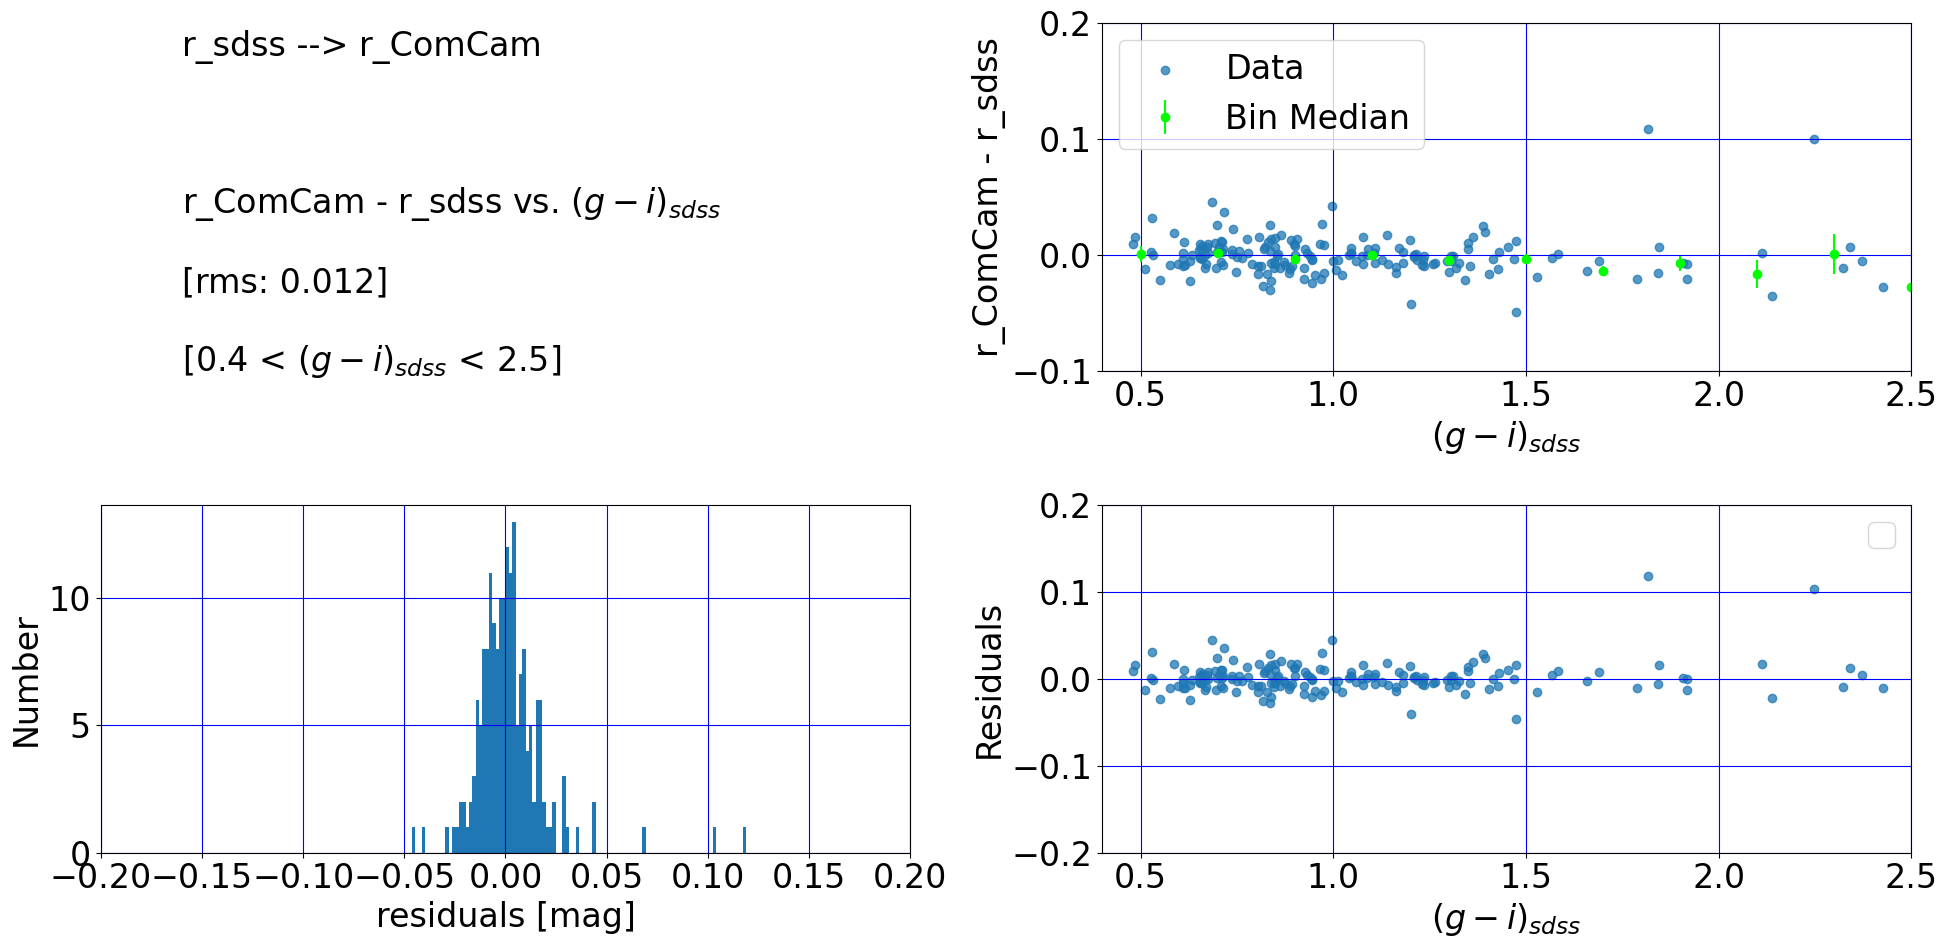

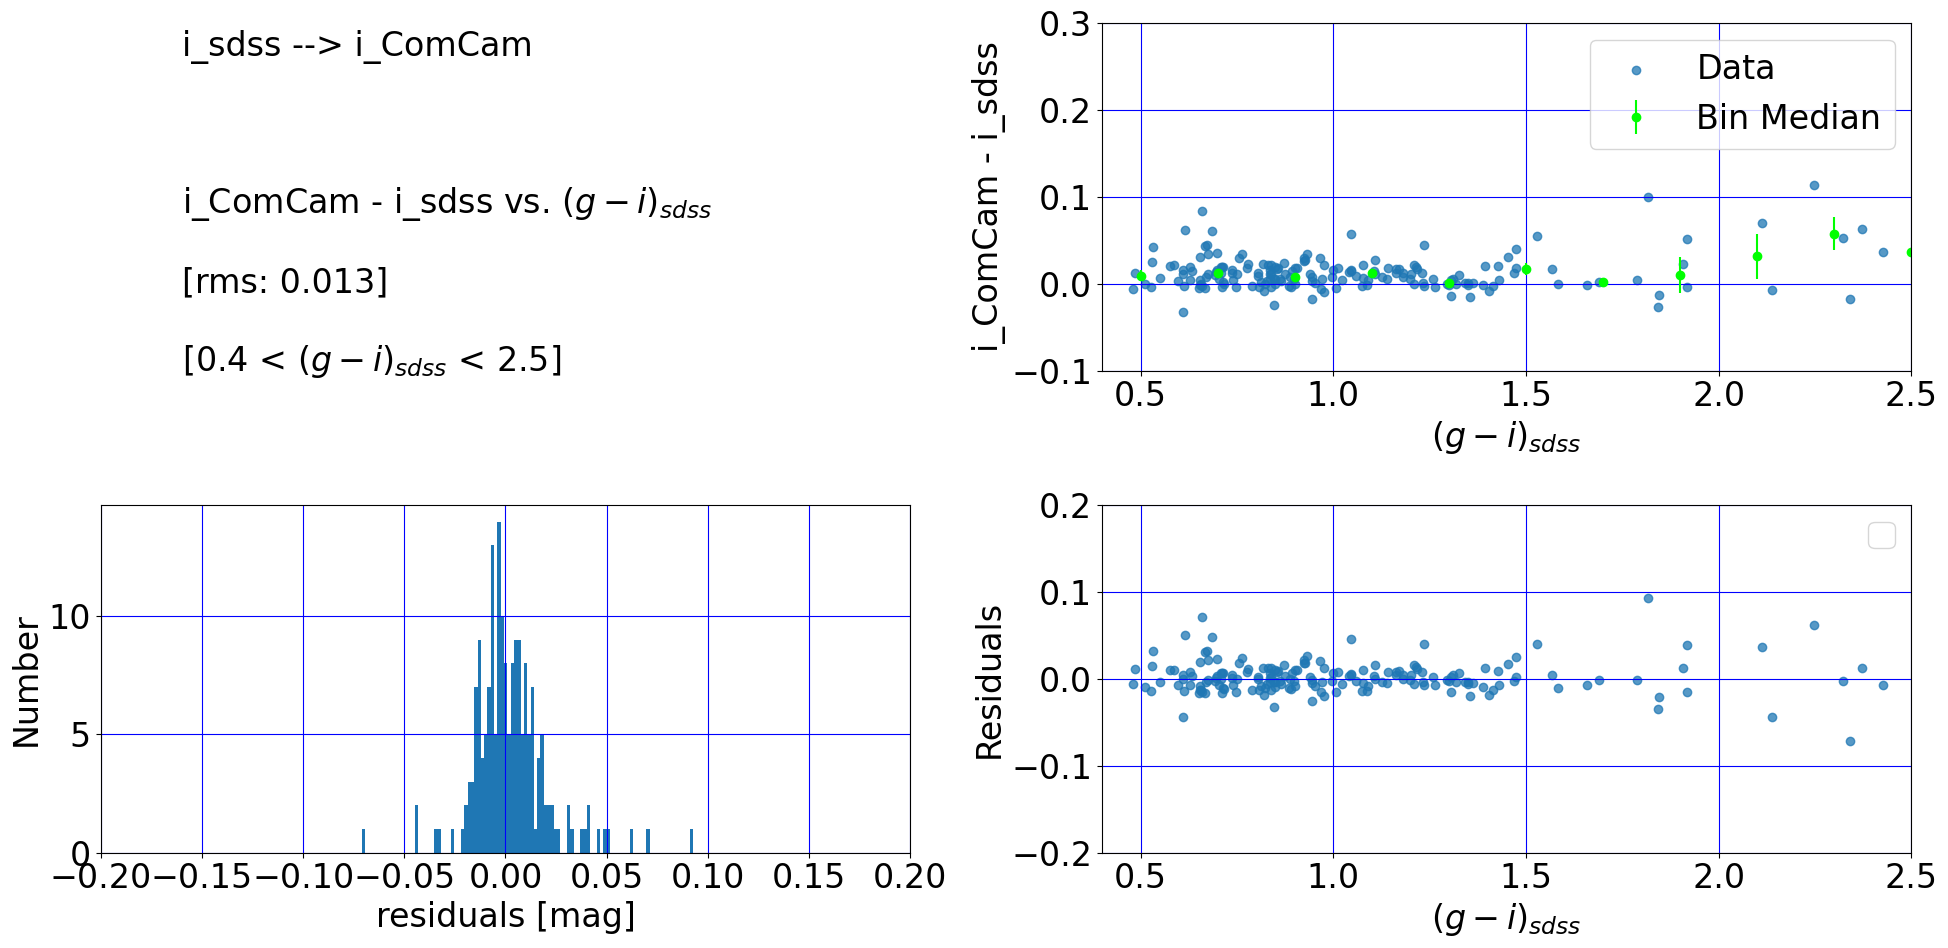

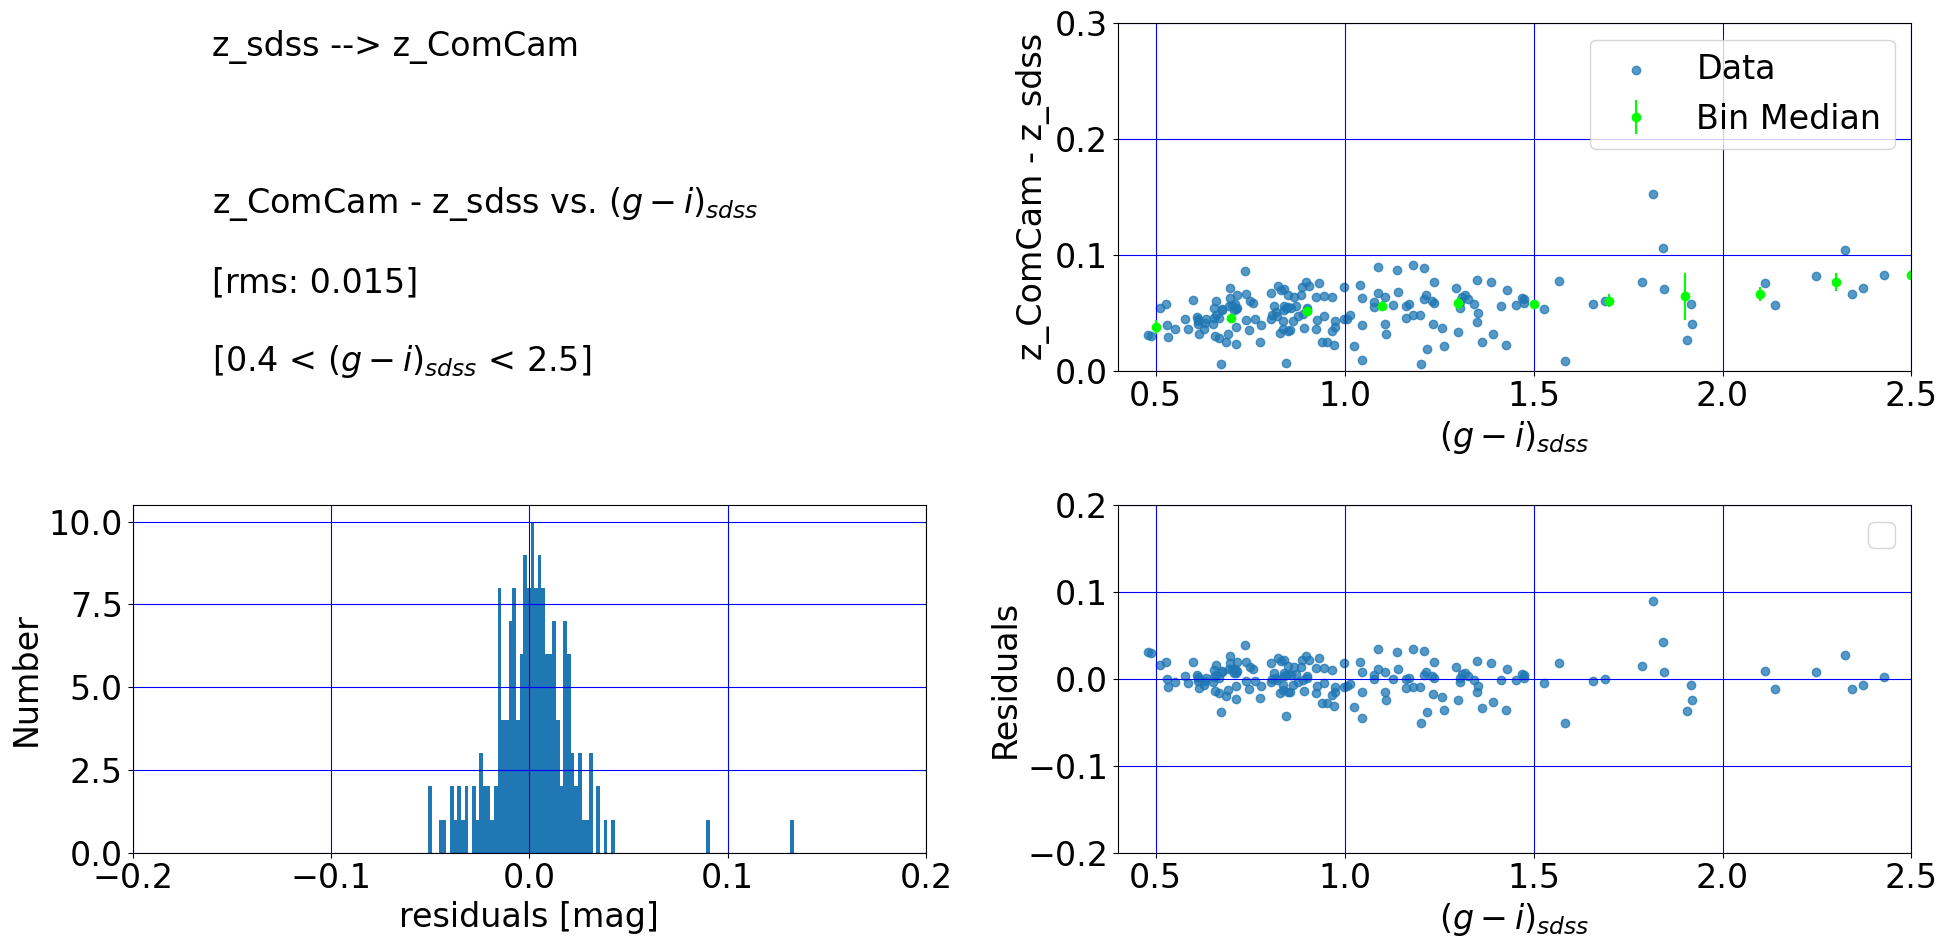

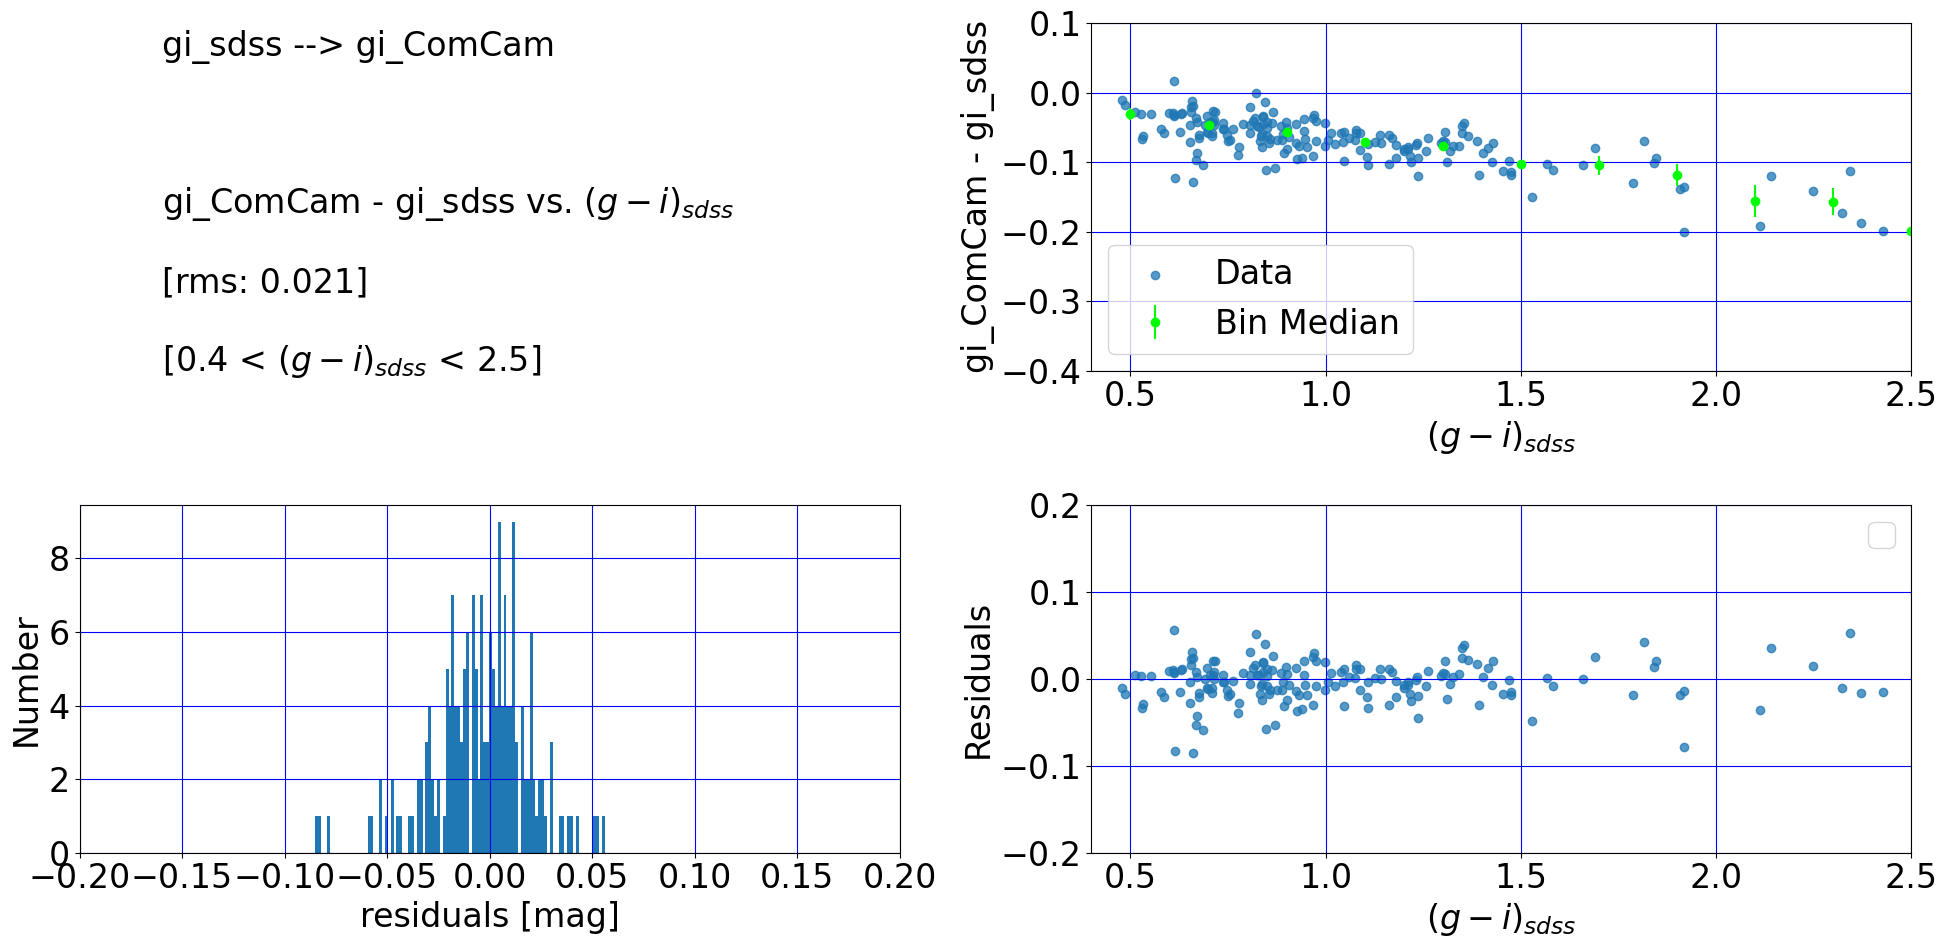

In [36]:
# --- Accumulator for ALL bands ---
qa_rows_all = []

# --- Main loop ---
for band in bandList:
    
    print("")
    print("")
    print("") 
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(band)
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print("")
    
    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) )
    mask = mask & mask1 & mask2

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag and color1 series...
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]


    # Calculate the color range to bin and the number of bins, 
    #  based on the 0.01%-99.99% color range...
    #color1_desc = df[color_name_1].describe(percentiles=[0.0001, 0.9999])
    #color1_min = math.floor(10*color1_desc['0.01%'])/10.
    #color1_max = math.ceil(10*color1_desc['99.99%'])/10.
    color1_desc = df[color_name_1].describe(percentiles=[0.01, 0.99])
    color1_min = math.floor(10*color1_desc['1%'])/10.
    color1_max = math.ceil(10*color1_desc['99%'])/10.
    if verbose>1:
        print("")
        print(color1_desc)
        print(color1_min, color1_max)
        print("")
    binsize = color_binsize
    ranges = np.arange(color1_min,color1_max+binsize,binsize)
    # Label the bins by their mid-point...
    labels = np.arange(color1_min,color1_max,binsize) + 0.5*binsize
    
    #nbins = int((color1_max-color1_min)/binsize)+1
    #ranges = np.linspace(color1_min, color1_max, nbins+1)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins) + 0.5*binsize

    #nbins = math.floor((color1_max-color1_min)/binsize) + 1
    #ranges = np.linspace(color1_min, color1_max, nbins)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins-1) + 0.5*binsize
    
    if verbose:
        print(ranges)
        print(labels)
    
    # Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
    df['bin_interval'] = pd.cut(df[color_name_1], bins=ranges, precision=0)
    df['bin_label'] = pd.cut(df[color_name_1], bins=ranges, labels=labels)
    if verbose>1:
        print("")
        print(df[[color_name_1,'bin_interval','bin_label']].head())
        print("")

    # Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
    df_grp = df.groupby(['bin_label'])
    bin_interval = df_grp['bin_interval'].first()
    dmag_num = df_grp['dmag'].count()
    dmag_mean = df_grp['dmag'].mean()
    dmag_sd = df_grp['dmag'].std()
    dmag_err = dmag_sd/np.sqrt(dmag_num-1)
    dmag_median = df_grp['dmag'].median()
    dmag_rsd = df_grp['dmag'].apply(robustStdDev)
    dmag_unc = np.sqrt(np.pi/2)*dmag_rsd/np.sqrt(dmag_num)
    #dmag_rsd = dmag_sd
    #dmag_unc = dmag_err

    # Rename some of the pandas series...
    dmag_num.name    = 'bin_num'
    dmag_mean.name   = 'bin_mean'
    dmag_sd.name     = 'bin_stddev'
    dmag_err.name    = 'bin_stderr'
    dmag_median.name = 'bin_median'
    dmag_rsd.name    = 'bin_rstddev'
    dmag_unc.name    = 'bin_unc'
    
    # Create new data frame containing all the relevant aggregate quantities...
    df1 = pd.concat( [bin_interval, dmag_num, \
                      dmag_mean, dmag_sd, dmag_err, \
                      dmag_median, dmag_rsd, dmag_unc, ], \
                    join='outer', axis=1 )
    
    if verbose>1:
        print("")
        print(df1)
        print("")
    
    
    # Create results output file...
    resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
    df1.to_csv(resultsFile)
    if verbose>1:
        print("""Writing binned values to %s""" % (resultsFile))

    
    # Create name for QA plot output file...
    outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)

    # Create title and labels for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagLabel = """%s - %s""" % (magName, magName_match)


    # Create QA plots...
    status = interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                                     title, dmagLabel, outputFileName, verbose)

    # Calculate the 'robust' RMS of the residuals....
    #rms_val = df1['bin_rstddev'].median()  # or mean, or df1['bin_unc'].median()
    rms_val = robustStdDev(df['res'].values)
    rms_val = round(rms_val, 3)

    conversion_str = make_conversion_str(magName_match, magName)
    range_str = make_range_str_interp(color1_min, color1_max, colorLabel_1)

    qa_rows_all.append({
        "Conversion": conversion_str,
        "RMS": rms_val,
        "Applicable Color Range": range_str,
        "QA Plot": f"[link](_static/plots/{outputFileName})",
        "Lookup Table": f"[link](_static/data/{resultsFile})"
    })


# --- After ALL bands processed: display one big table ---
if qa_rows_all:
    qa_df_all = pd.DataFrame(qa_rows_all)
    md_table_str = qa_df_all.to_markdown(index=False)
    md_table_str = md_table_str.replace(r'\_', '_')
    print(md_table_str)

    if write_md_file:
        with open(md_filename, "w") as f:
            f.write(md_table_str)
        print(f"\nMarkdown table written to: {md_filename}")
  